# Import and loading

In [46]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD, IncrementalPCA, TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.svm import SVR, SVC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import prince
import optuna
import numpy as np

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
data = Loader.load_by_fueltype("Combustion")

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

# Functions

In [24]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we rem['Combustion']ove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    cols_mode = ['displacement_liters','doors','seatingCapacity','number_of_cylinders','cubicCapacity',"dimensions.length","dimensions.height","Llantas_Diametro_cm","number_of_cylinders","bore_diameter","stroke_length"]
    #fill the elemental columns that has a minor amount of missing data with the mode
    for col in cols_mode:
        numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, col)

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_torque")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_power")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df


# Column filters

In [25]:
# Quit all electric columns from data['Combustion']
for column in data.columns:
    if column.startswith('electric'):
        data = data.drop(columns=column)

In [26]:
# convert object columns to category
data = category_convert(data)

categorical_columns = get_combustion_categorical_columns(data)

categorical_columns = fill_combustion_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#categorical_columns['traction']

Number of missing values in 'front_suspension' before filling with 'unknown': 30
Number of missing values in 'rear_suspension' before filling with 'unknown': 78
Number of missing values in 'environmentalLabel' before filling with 'unknown': 11
Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [27]:
# Drop all na columns 
data = drop_columns_full_nan(data)

numerical_columns = get_combustion_numerical_columns(data)


# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data[numerical_columns.columns] = numerical_columns

#correlation_matrix = numerical_columns.corr()
#correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)
print(missing_values_num)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6154091221985554%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 17.70914536272189%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 6.410215656255401%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.903819131160218%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.824540773438649%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 2.55180902596012e+16%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_torque: 67.97560330482807%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_power: 20.028480167086347%
Series([], dtype: int64)


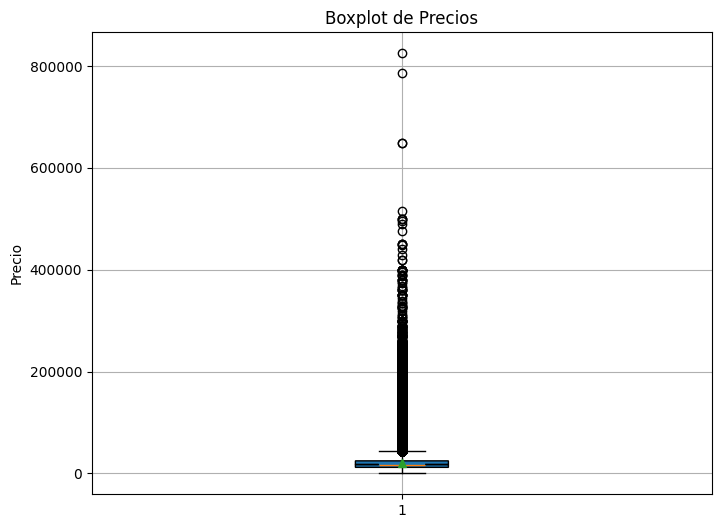

In [28]:
precios_combustion = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_combustion, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

Even though there seems to be many outliers in the data, after a manual inspection, it was found that the data is correct and the outliers are valid data points. (Most of them are from luxury brands such as Lamborghini, Ferrari, etc.)

In [29]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)[:10]

43901.5


,price,brand
idx,,
48458,825000,MERCEDES-BENZ
38166,786500,FERRARI
16685,648500,FERRARI
18873,648500,FERRARI
119510,515000,PORSCHE
16086,499900,FERRARI
78396,499900,LAMBORGHINI
76218,499900,LAMBORGHINI
19151,495000,LAMBORGHINI


# PCA

In [30]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [31]:
principal_components

array([[-0.94936538, -1.95424871],
       [-0.09526035, -0.50605691],
       [12.15540408,  3.56908054],
       ...,
       [-0.97962288, -0.29182012],
       [-3.21372284,  2.53701734],
       [-4.00545634, -1.52924421]])

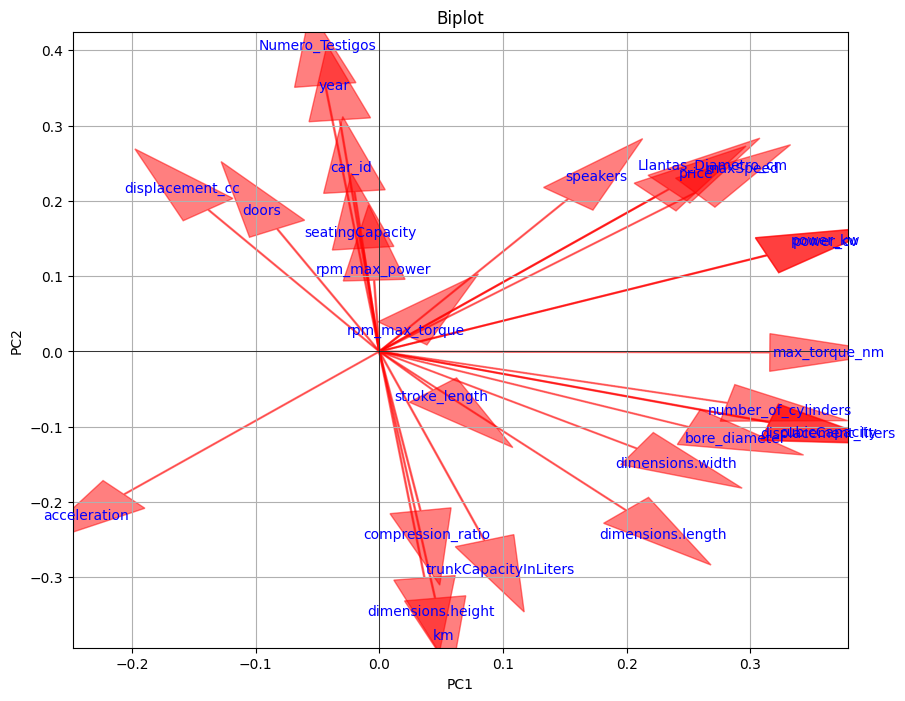

In [32]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

# Test CART regression trees with only numerical variables

In [33]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]

# Since too many features + rows are present, we will use PCA to reduce the dimensionality
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check PCA-transformed data
print(f"Original shape: {X.shape}, Transformed shape: {X_pca.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

Original shape: (129204, 26), Transformed shape: (129204, 17)


DecisionTreeRegressor(random_state=42)

MAE: 2275.2995339521353 
 MSE: 57882217.11892269 
 RMSE: 7608.036351051609 
 R2: 0.8693807758805843 
 MAPE: 12.033195862303094
Mean: 2275.2995339521353
Variance: 52705229.14971987
Standard Deviation: 7259.836716464074


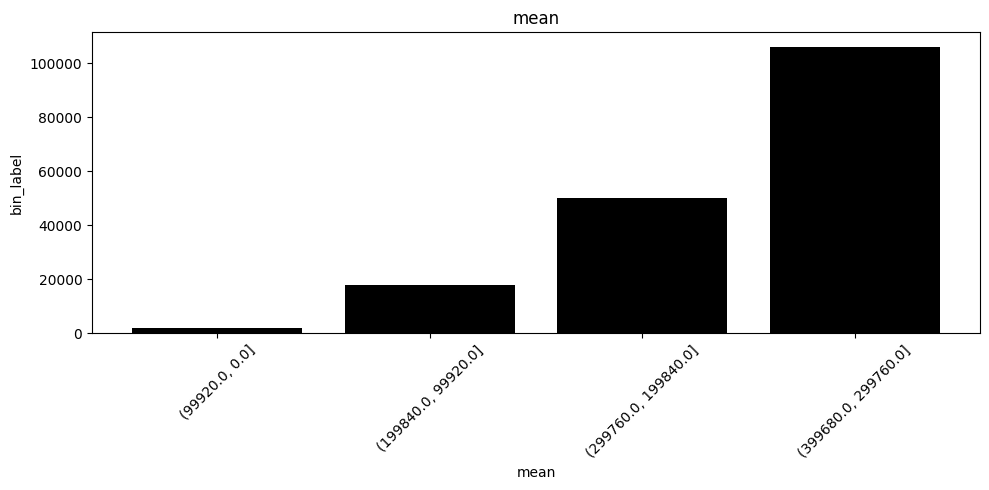

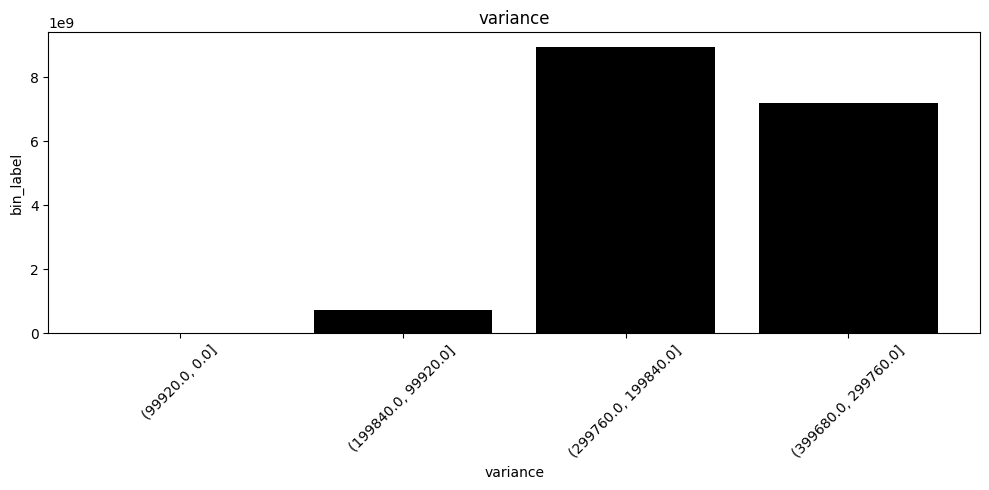

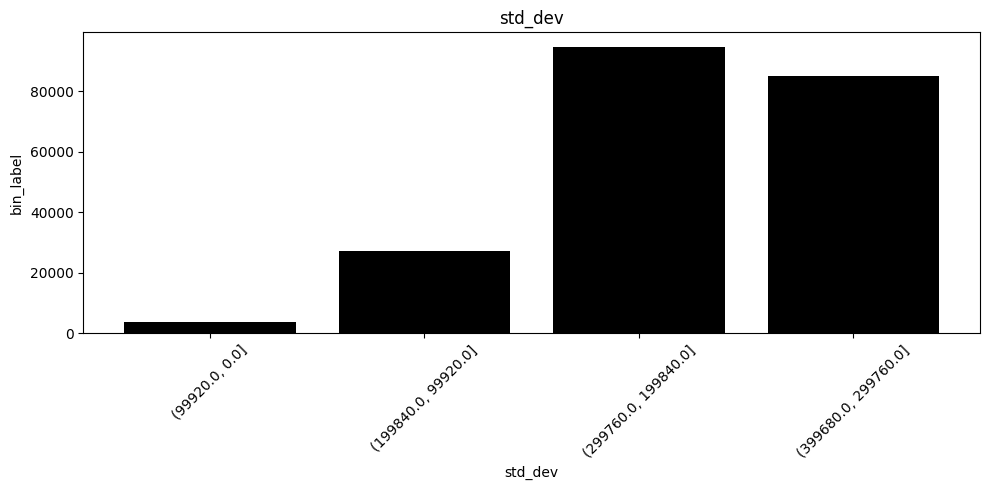

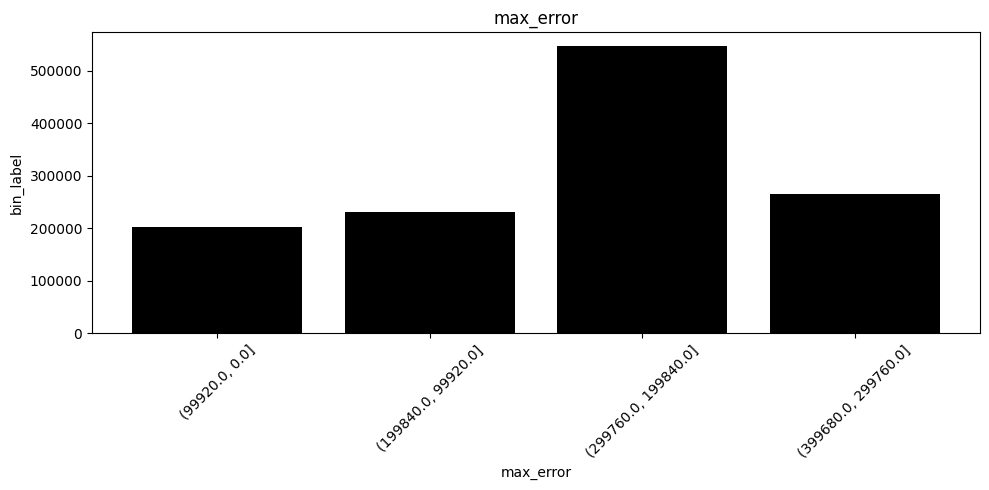

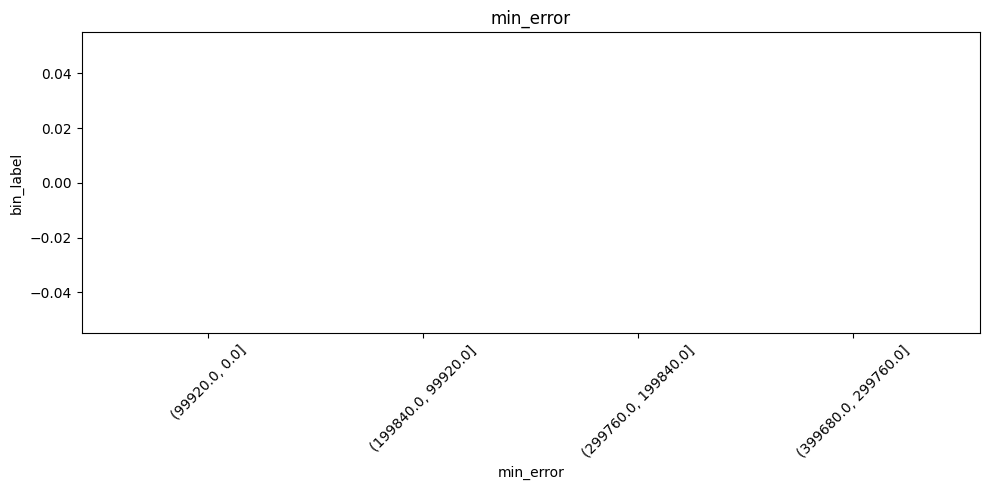

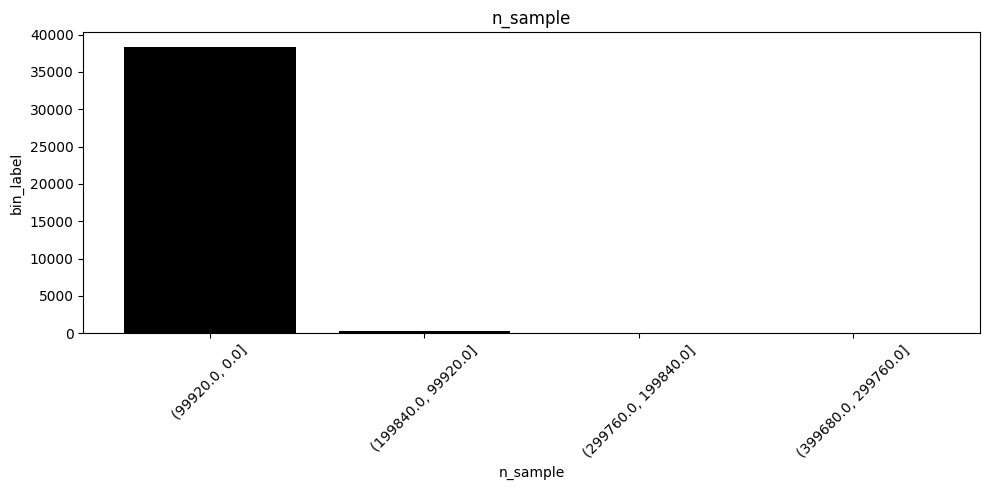

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(99920.0, 0.0]",2010.565162,1.425405e+07,3775.453800,203000.0,0.0,38374
1,"(199840.0, 99920.0]",17904.078125,7.468283e+08,27328.158704,230900.0,0.0,288
2,"(299760.0, 199840.0]",49946.071429,8.958611e+09,94649.937944,546500.0,0.0,77
3,"(399680.0, 299760.0]",106106.312500,7.197967e+09,84840.833685,266000.0,0.0,16


In [34]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

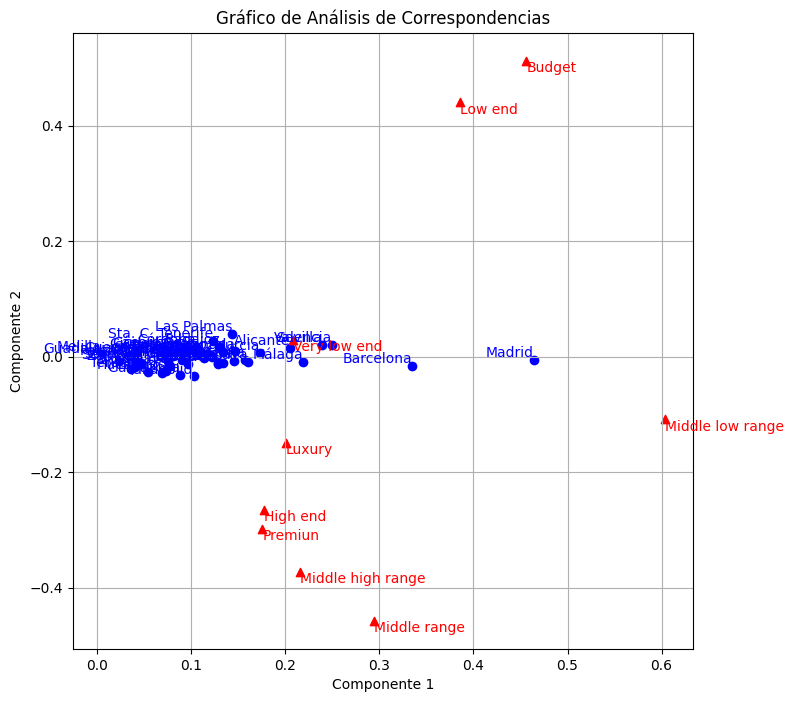

In [35]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [36]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     47015
Budget               26867
Low end              19272
Middle range         11219
Middle high range     6014
Very low end          5609
Luxury                5182
High end              4049
Premiun               3977
Name: count, dtype: int64

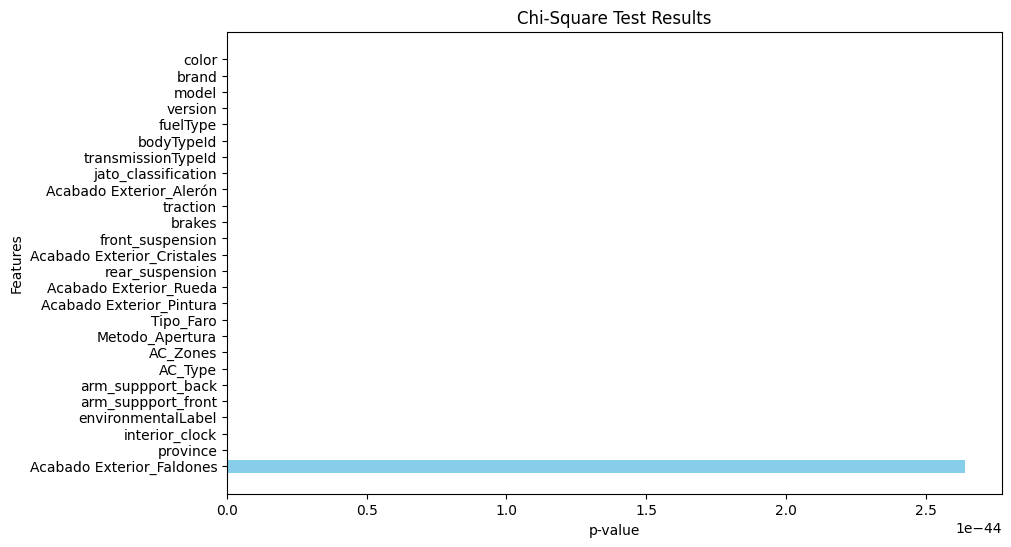

Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'jato_classification', 'Acabado Exterior_Alerón',
       'traction', 'brakes', 'front_suspension', 'Acabado Exterior_Cristales',
       'rear_suspension', 'Acabado Exterior_Rueda', 'Acabado Exterior_Pintura',
       'Tipo_Faro', 'Metodo_Apertura', 'AC_Zones', 'AC_Type',
       'arm_suppport_back', 'arm_suppport_front', 'price_categ'],
      dtype='object')

In [37]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

# Categorical

## Test CART tree classifier with only categorical values

In [38]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)

In [39]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
35700,Budget,Budget,0
157809,Budget,Budget,0
46442,Low end,Low end,0
164823,Budget,Budget,0
104592,Budget,Budget,0
...,...,...,...
76424,Middle low range,Middle low range,0
148454,Middle low range,Middle low range,0
72048,Luxury,High end,2


In [40]:
# Calcular la precisión
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7073164439399412 
 Precision: 0.7041710782742121 
 Recall: 0.7073164439399412 
 F1 Score: 0.7054595466776329
Confusion Matrix:
 [[11637    35   114     6   109  1461   689    24    12]
 [   75   520     2    31   291     3   148   196     0]
 [  128     1  4052     3     3  1076     4     2   476]
 [   14    35     3  1276    17     3     9   194     2]
 [  199   216     2     9   804     7   467    57     1]
 [ 1336     2  1227     0     3  5512    17     2    29]
 [ 1117    82    10     8   343    20  1805    31     2]
 [   29   191     2   131    83     4    57   641     1]
 [   14     0   450     0     2    27     0     1  1170]]


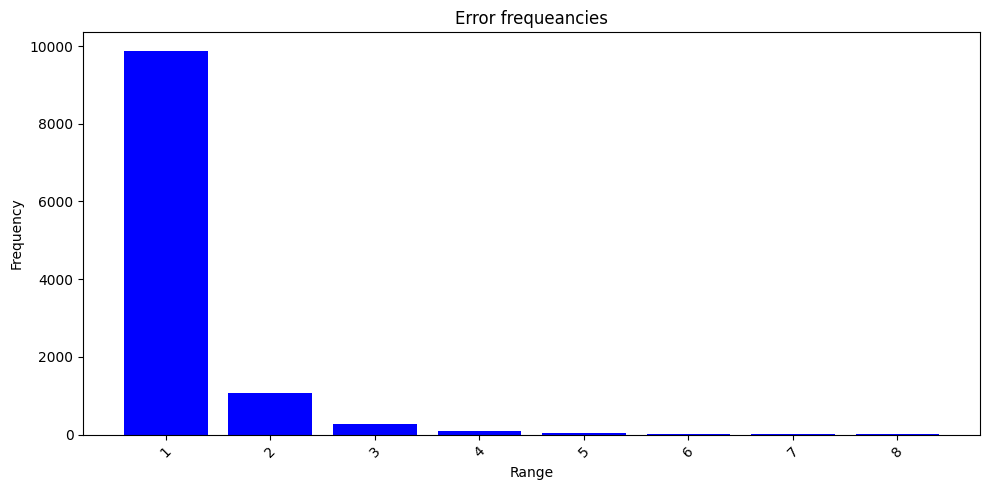

{np.int64(1): np.int64(9861), np.int64(2): np.int64(1079), np.int64(3): np.int64(274), np.int64(4): np.int64(82), np.int64(5): np.int64(32), np.int64(6): np.int64(7), np.int64(7): np.int64(8), np.int64(8): np.int64(2)}
Error mean: 1.1849272807404143
Error rate: 29.26835560600588 %
Overall mean: 0.3468087301996801


In [41]:
Evaluator.eval_ordinal_classification (result["diff"])

Even though the accuracy is only about 70% the errors are not a concern as many of the errors are of degree 1 (the guess was not far off)

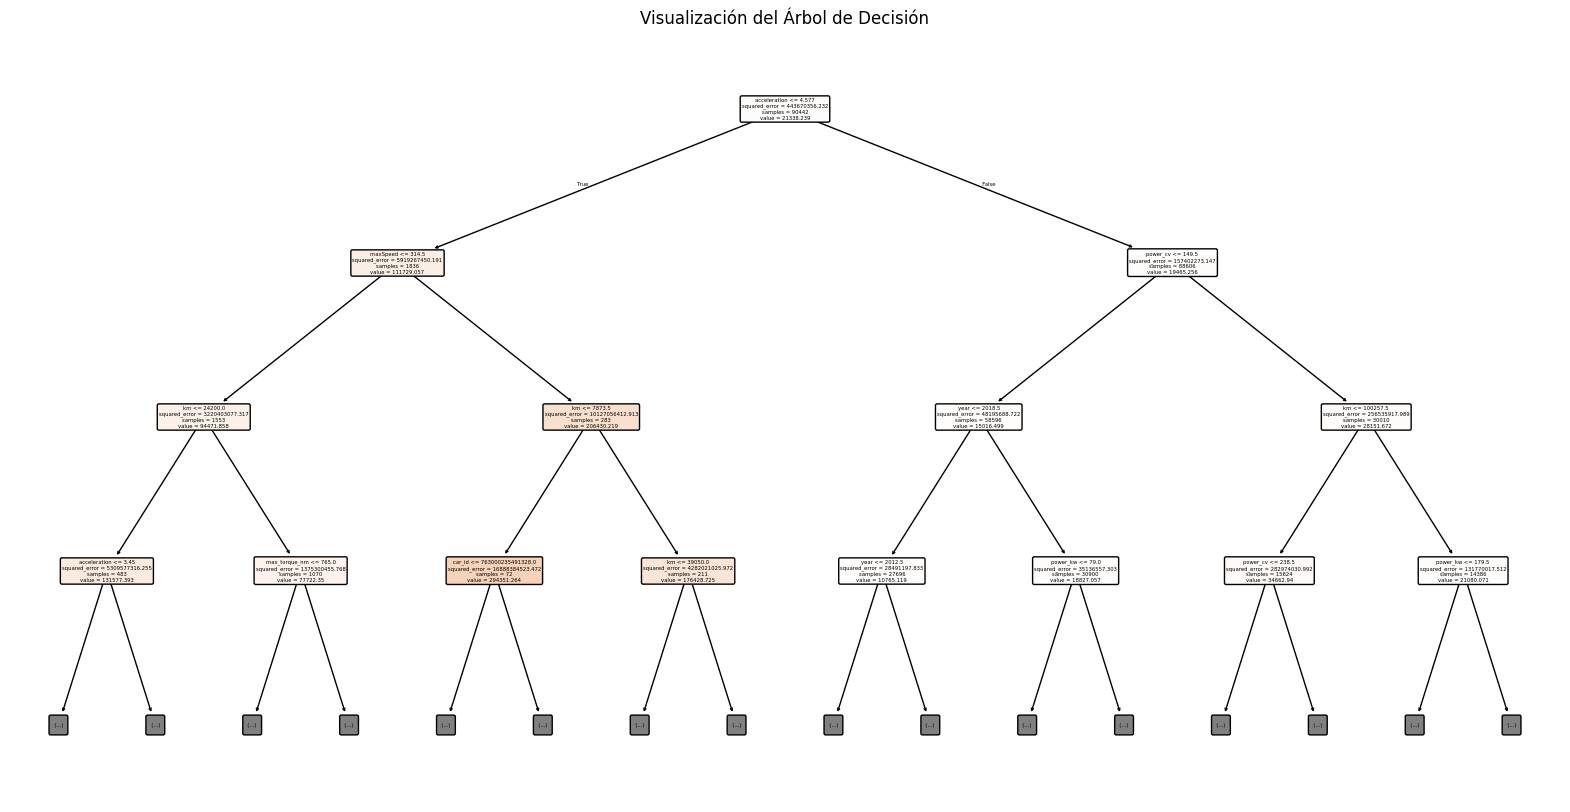

In [42]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

In [43]:
# Merge numerical and categorical columns
combustion_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how="inner")
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

# Separate target variables
target = combustion_cars[["price", "price_categ"]]
combustion_cars.drop(columns=["price", "price_categ"], inplace=True)

# Update feature lists by removing targets
numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

# Initialize dictionary to store encoders/scalers
encoders_and_scalers = {}

# Scale and apply PCA to numerical columns
numerical_data = combustion_cars[numerical_column_names]
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Apply IncrementalPCA to numerical data
incremental_pca_numerical = PCA(n_components=0.95)
numerical_data_pca = incremental_pca_numerical.fit_transform(numerical_data_scaled)

# Store the scaler and PCA for numerical columns
encoders_and_scalers["numerical_scaler"] = scaler
encoders_and_scalers["numerical_pca"] = incremental_pca_numerical

# Encode categorical columns (sparse matrix)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
categorical_data_encoded = encoder.fit_transform(combustion_cars[categorical_column_names])

# Instead of PCA on categorical data, use TruncatedSVD for sparse matrix
svd_categorical = TruncatedSVD(n_components=30)
categorical_data_svd = svd_categorical.fit_transform(categorical_data_encoded)

# Store the encoder and SVD for categorical columns
encoders_and_scalers["categorical_encoder"] = encoder
encoders_and_scalers["categorical_svd"] = svd_categorical

# Combine the PCA-transformed numerical and SVD-transformed categorical data
combustion_cars_encoded = pd.DataFrame(
    data=np.hstack([numerical_data_pca, categorical_data_svd]),
    index=combustion_cars.index
)

print("Shape after dimensionality reduction:")
print(combustion_cars_encoded.shape)




Shape after dimensionality reduction:
(129204, 47)


## Classification

In [44]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)
x, y = combustion_cars_encoded, target['price_categ']

In [77]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)

def objective(trial, x, y, classifier_name):
    x, y = combustion_cars_encoded, target['price_categ']

    match classifier_name:
        case "SVC":
            C = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
            classifier_obj = SVC(C=C, gamma="auto")
        case "RandomForest":
            max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
            classifier_obj = RandomForestClassifier(max_depth=max_depth, n_estimators=10)
        case "CART":
            max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
            classifier_obj = DecisionTreeClassifier(max_depth=max_depth)

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

[I 2024-12-21 16:33:19,820] A new study created in memory with name: no-name-3038431c-006e-491f-8af6-a027c465470c
[I 2024-12-21 16:33:25,943] Trial 0 finished with value: 0.7086158323271725 and parameters: {'max_depth': 29}. Best is trial 0 with value: 0.7086158323271725.


FrozenTrial(number=0, state=1, values=[0.7086158323271725], datetime_start=datetime.datetime(2024, 12, 21, 16, 33, 19, 820147), datetime_complete=datetime.datetime(2024, 12, 21, 16, 33, 25, 943569), params={'max_depth': 29}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=32, log=True, low=2, step=1)}, trial_id=0, value=None)


## Cart

[I 2024-12-21 16:33:27,678] A new study created in memory with name: no-name-2ee600fa-882b-48ac-a452-2581be8dc1d7
[I 2024-12-21 16:33:28,946] Trial 0 finished with value: 0.41400421039596297 and parameters: {'max_depth': 2}. Best is trial 0 with value: 0.41400421039596297.
[I 2024-12-21 16:33:30,191] Trial 1 finished with value: 0.41295161140521963 and parameters: {'max_depth': 2}. Best is trial 0 with value: 0.41400421039596297.
[I 2024-12-21 16:33:34,144] Trial 2 finished with value: 0.6522166496393301 and parameters: {'max_depth': 10}. Best is trial 2 with value: 0.6522166496393301.
[I 2024-12-21 16:33:35,394] Trial 3 finished with value: 0.4240116405064858 and parameters: {'max_depth': 2}. Best is trial 2 with value: 0.6522166496393301.
[I 2024-12-21 16:33:40,719] Trial 4 finished with value: 0.7082443268010278 and parameters: {'max_depth': 17}. Best is trial 4 with value: 0.7082443268010278.
[I 2024-12-21 16:33:42,668] Trial 5 finished with value: 0.5160056964180676 and parameters

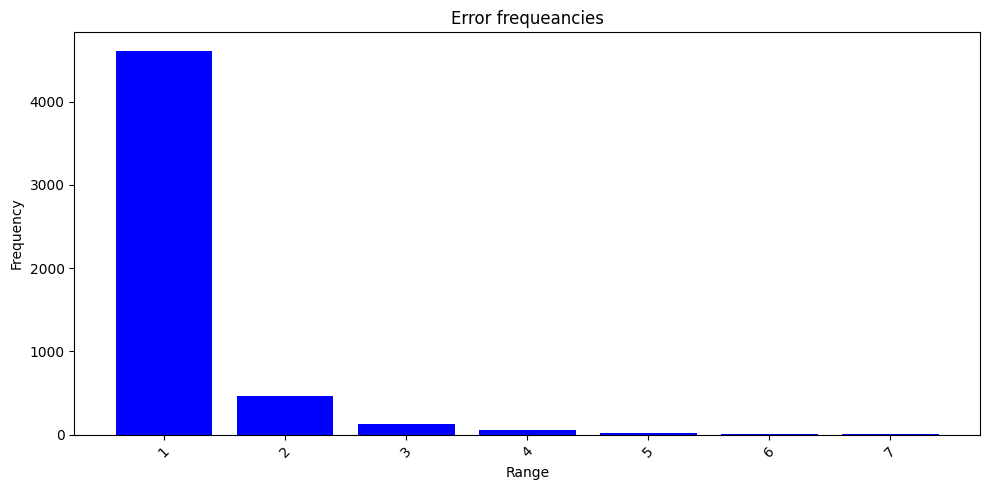

{np.int64(1): np.int64(4602), np.int64(2): np.int64(462), np.int64(3): np.int64(128), np.int64(4): np.int64(57), np.int64(5): np.int64(23), np.int64(6): np.int64(9), np.int64(7): np.int64(4)}
Error mean: 1.1986754966887416
Error rate: 13.63448738455188 %
Overall mean: -0.0015737062071100563
Accuracy: 0.7299674939373614 
 Precision: 0.7280978843634016 
 Recall: 0.7299674939373614 
 F1 Score: 0.7289358148051838
Confusion Matrix:
 [[ 5756    13   969     6    12  1305    31     5    31]
 [   10   598     2    33   295    43   108   176     1]
 [ 1030     5  4140     3     4   140     6     4   413]
 [    6    31     4  1336    11    13    14   138     0]
 [    6   242     7    18   871   111   452    53     2]
 [ 1247    58    96    18   133 11836   662    32     5]
 [   25   101    12    28   353   922  1949    27     1]
 [    6   166     2   138    60    25    51   691     0]
 [   26     0   506     1     1     9     1     2  1118]]


In [78]:

classifier_name = "RandomForest"

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, x,y,classifier_name), n_trials=100)

max_depth = study.best_params.get("max_depth")

classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42, max_depth=max_depth), classifier_name)

## Random Forest

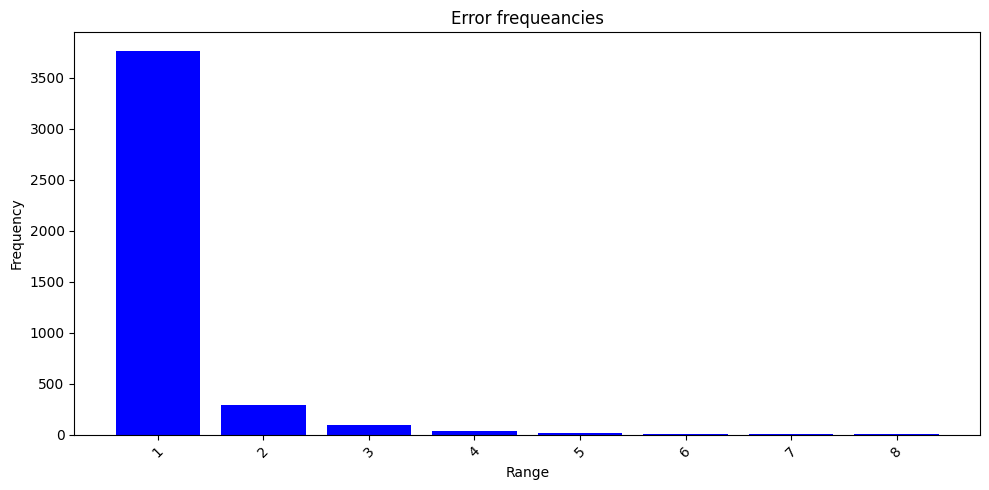

{np.int64(1): np.int64(3757), np.int64(2): np.int64(293), np.int64(3): np.int64(93), np.int64(4): np.int64(30), np.int64(5): np.int64(17), np.int64(6): np.int64(2), np.int64(7): np.int64(1), np.int64(8): np.int64(1)}
Error mean: 1.1573676680972818
Error rate: 10.819875135441928 %
Overall mean: 0.016872194417212733
Accuracy: 0.7925029668231773 
 Precision: 0.7889451453210985 
 Recall: 0.7925029668231773 
 F1 Score: 0.7899854888987209
Confusion Matrix:
 [[ 6359     3   723     0     1  1028     6     0     8]
 [    2   648     3    27   291    40    70   185     0]
 [  852     0  4577     0     2    56     1     0   257]
 [    2    18     1  1392     6    12     4   117     1]
 [    3   223     2     4   976   115   399    40     0]
 [  907    11    45     2    34 12670   405     8     5]
 [    2    44    14     6   268   921  2151    12     0]
 [    2   142     0   138    35    22    25   775     0]
 [    8     0   479     0     0     5     1     0  1171]]


In [26]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

## SVM

In [27]:
#classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

## Naive Bayes

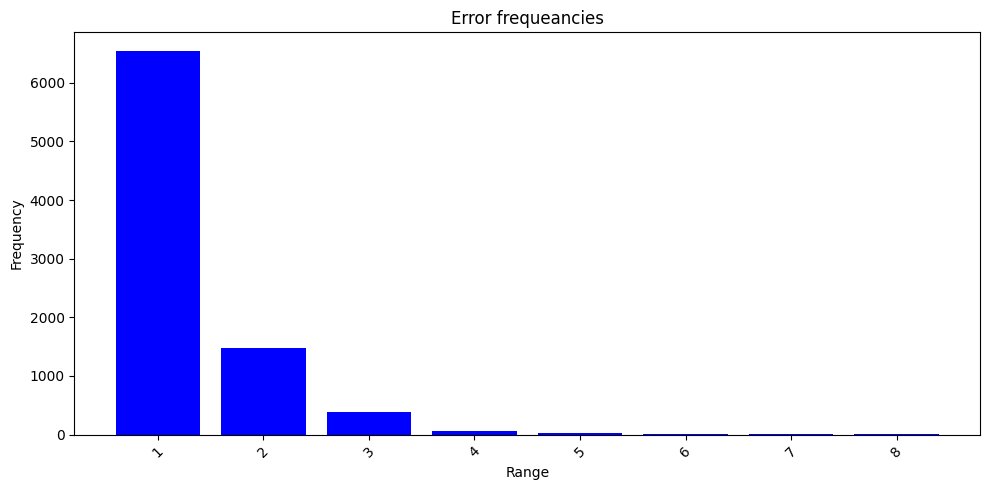

{np.int64(1): np.int64(6533), np.int64(2): np.int64(1484), np.int64(3): np.int64(384), np.int64(4): np.int64(55), np.int64(5): np.int64(25), np.int64(6): np.int64(7), np.int64(7): np.int64(4), np.int64(8): np.int64(3)}
Error mean: 1.3057092407298412
Error rate: 21.915793818688407 %
Overall mean: -0.07953665961508694
Accuracy: 0.5346473350188329 
 Precision: 0.5386207074902306 
 Recall: 0.5346473350188329 
 F1 Score: 0.5155676603839023
Confusion Matrix:
 [[ 4101    51   967    51   105  2647    22    26   158]
 [    0    99     7    87   730    94    19   226     4]
 [ 1937    12  2257    32    18   223    11    12  1243]
 [    2    20     4   955   210    16    13   330     3]
 [    1    77     8    62  1002   433    37   140     2]
 [ 1502   119   237   115  1357 10557    52    98    50]
 [   35    74    21    63  1373  1675    59   114     4]
 [    0    49     1   171   582    30     8   298     0]
 [   19     2   230     4     1     8     1     3  1396]]


In [28]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes") # GaussianNB seems to give the best results

## ANN

In [29]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    combustion_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5823 - loss: 1.0920 - val_accuracy: 0.7214 - val_loss: 0.6762
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7333 - loss: 0.6553 - val_accuracy: 0.7376 - val_loss: 0.6312
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7510 - loss: 0.6032 - val_accuracy: 0.7457 - val_loss: 0.6139
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7600 - loss: 0.5836 - val_accuracy: 0.7474 - val_loss: 0.6103
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7675 - loss: 0.5656 - val_accuracy: 0.7539 - val_loss: 0.5924
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7720 - loss: 0.5555 - val_accuracy: 0.7613 - val_loss: 0.5832
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7785 - loss: 0.5382 - val_accuracy: 0.7618 - val_loss: 0.5786
Epoch 8/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7813 - loss: 0.5336 - val_accu

In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step


In [31]:
Evaluator.eval_classfication(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.7660595428512461 
 Precision: 0.7673736749189031 
 Recall: 0.7660595428512461 
 F1 Score: 0.7664133602559228
Confusion Matrix:
 [[ 6158     2   971     3     3   968     8     0    15]
 [    2   610     2    18   278    19    78   258     1]
 [  762     2  4568     1     3    58     3     0   348]
 [    2    22     1  1329     5     3     5   184     2]
 [    3   301     0    11   905    46   430    66     0]
 [ 1257    16    50     3    66 11941   738     8     8]
 [    6    54     7     5   435   733  2151    27     0]
 [    1   157     0   111    44     4    17   805     0]
 [    7     0   422     0     0     5     2     1  1227]]


## Regression

In [32]:
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [33]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="MAPE")

### Cart

MAE: 2609.9842189986425 
 MSE: 67598707.40712145 
 RMSE: 8221.84330957003 
 R2: 0.8474541724127042 
 MAPE: 13.738864660136446
Mean: 2609.9842189986425
Variance: 60786689.783699505
Standard Deviation: 7796.581929518827
r2_adjusted: 0.8472689770338592


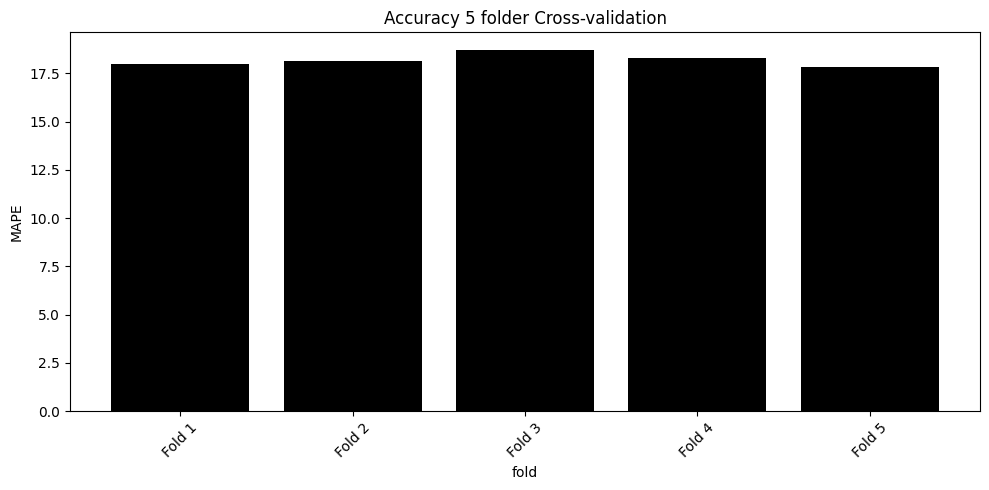

In [34]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### Random Forest

MAE: 1968.2134931307387 
 MSE: 30238036.139681865 
 RMSE: 5498.912268774786 
 R2: 0.9317636915782743 
 MAPE: 10.804193722554736
Mean: 1968.2134931307387
Variance: 26364171.785139948
Standard Deviation: 5134.6053193152
r2_adjusted: 0.9316808505777107


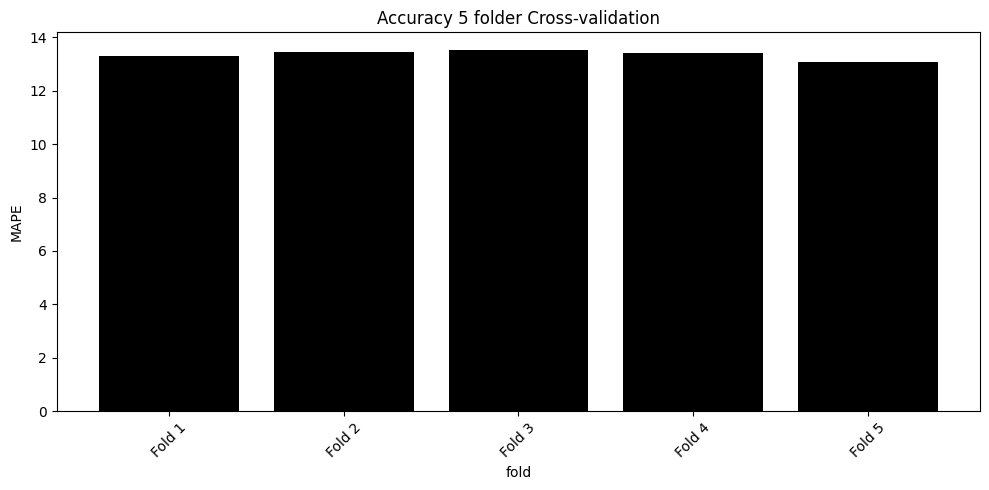

In [35]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

In [ ]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

### Multivariable Regression

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [ 4503.13238718 -4760.94440835  1851.36212853 -3807.47256038
  -552.01517147  1430.44775138  -868.61945716   -47.24364957
 -1152.78321671  2341.53103996 -2048.30341957 -1917.79190677
  1239.50380103 -2224.58487165 -1695.80263199  2433.15695243
 -1755.37217535 -2519.24769035 -1410.58810276  -285.33522183
  2578.46688845  -291.84247316   180.68018198  -402.28656267
  -901.6856687   -591.44996996   935.37558266  -114.31719151
    48.09637989 -1192.12082362   475.7292759   -299.89554621
  1823.88476649  1116.4132613   1040.42083356   129.76347802
  -633.79673138  -812.66396119 -3927.27034419  1464.51519654
   657.38869211  3259.1420991    516.78972822   721.05722265
   562.61082444 -1988.21226899  2696.38329488]
Intercept: 28830.543913029334


In [ ]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

## ANN

### Regression

In [ ]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 474389600.0000 - mae: 12550.5488 - val_loss: 110985664.0000 - val_mae: 4246.3350
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 102491568.0000 - mae: 4080.2756 - val_loss: 84536824.0000 - val_mae: 3630.6555
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 91102160.0000 - mae: 3666.6357 - val_loss: 68768656.0000 - val_mae: 3411.6685
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 71548648.0000 - mae: 3361.0291 - val_loss: 57667020.0000 - val_mae: 3170.2422
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 50110200.0000 - mae: 3094.2961 - val_loss: 52009324.0000 - val_mae: 3024.1328
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - loss: 53210872.0000 - mae: 3013.3335 - val_loss: 49626376.0000 - val_mae: 2893.3811
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 47170200.0000 - mae: 2869.7078 - val_loss: 47894844.0000 - val_mae: 2868.4790
Epoch 8/100
7

In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

1212/1212 - 1s - 476us/step - loss: 31865970.0000 - mae: 2274.2080
Mean Absolute Error on test set: 2274.21


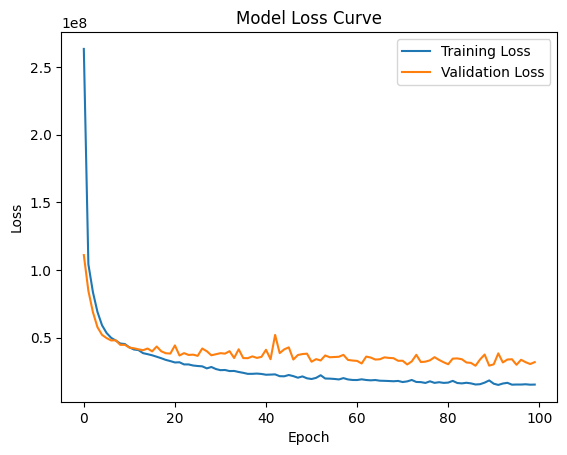

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step


In [ ]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 2274.207410893963 
 MSE: 31865944.335055918 
 RMSE: 5644.992855182008 
 R2: 0.9280900955200195 
 MAPE: 12.472926230121374
Mean: 2274.207410893963
Variance: 26693924.987290896
Standard Deviation: 5166.6163963749905
r2_adjusted: 0.9280027946595928


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(99920.0, 0.0]",2038.534055,7.435218e+06,2726.759618,143231.421875,0.117188,38374
1,"(199840.0, 99920.0]",18512.324395,5.254278e+08,22922.211100,167191.500000,67.992188,288
2,"(299760.0, 199840.0]",35243.609140,1.920061e+09,43818.499539,279682.200684,690.281250,77
3,"(399680.0, 299760.0]",74873.935059,5.748969e+09,75821.955487,280111.804688,1175.875000,16


In [ ]:
Evaluator.save("combustion")

Regression results saved to: evaluation/combustion_regression.tex
Classification results saved to: evaluation/combustion_classification.tex
